In [1]:
api_key = ""
channel_id = ""

In [2]:
from googleapiclient.discovery import build
youtube = build("youtube", "v3", developerKey=api_key)

In [3]:
def get_channel_videos(channel_id):
    res = youtube.channels().list(id=channel_id,
                                 part="contentDetails").execute()
    playlist_id = res["items"][0]["contentDetails"]["relatedPlaylists"]["uploads"]
    
    videos = []
    next_page_token = None
    
    while 1:
        res = youtube.playlistItems().list(playlistId=playlist_id,
                                          part="snippet",
                                          maxResults=50,
                                          pageToken=next_page_token).execute()
        videos += res["items"]
        next_page_token = res.get("nextPageToken")
        
        if next_page_token is None:
            break
    
    return videos

In [4]:
videos = get_channel_videos(channel_id)

In [5]:
res = youtube.videos().list(id=videos[0]["snippet"]["resourceId"]["videoId"],
                           part="statistics").execute()

In [6]:
video_ids = list(map(lambda x:x['snippet']['resourceId']['videoId'], videos))

In [7]:
def get_videos_stats(video_ids):
    stats = []
    for i in range(0, len(video_ids), 50):
        res = youtube.videos().list(id=','.join(video_ids[i:i+50]),
                                   part='statistics').execute()
        stats += res['items']
    return stats

In [8]:
stats = get_videos_stats(video_ids)

# List Before Dataframe

In [9]:
publishedAt = []
title = []
viewCount = []
likeCount = []
dislikeCount = []
commentCount = []

for i in range(len(videos)):
    publishedAt.append(videos[i]['snippet']['publishedAt'])
    title.append(videos[i]['snippet']['title'])
    viewCount.append(stats[i]['statistics']['viewCount'])
    likeCount.append(stats[i]['statistics']['likeCount'])
    dislikeCount.append(stats[i]['statistics']['dislikeCount'])
    commentCount.append(stats[i]['statistics']['commentCount'])

# Dataframe
공개일, 제목, 조회수, 좋아요수, 싫어요수, 댓글수

zip을 이용하여 list를 vertical하게 DataFrame으로 만든다.  
참고 링크 : https://stackoverflow.com/questions/54644722/how-to-vertically-align-lists-to-pandas-dataframe-in-python

In [27]:
import pandas as pd
names = ['publishedAt', 'title', 'viewCount', 'likeCount', 'dislikeCount', 'commentCount']
df = pd.DataFrame(data=list(zip(publishedAt, title, viewCount, likeCount, dislikeCount, commentCount)),
                 columns=names)

# int로 변환

In [28]:
df['viewCount'] = df['viewCount'].astype(int)
df['likeCount'] = df['likeCount'].astype(int)
df['dislikeCount'] = df['dislikeCount'].astype(int)
df['commentCount'] = df['commentCount'].astype(int)

# 좋아요/싫어요 비율

In [29]:
# 0으로 나누는 걸 방지하기 위해 0.001을 더했다.
df['likeRatio'] = df['likeCount'] / (df['likeCount'] + df['dislikeCount'] + 0.01)
len(df)

2606

# 라이브 영상 Drop하기

In [30]:
import re
def reg_live(word):
    if re.compile('라이브').search(word):
        return True
    else:
        return False

In [31]:
df['live'] = df['title'].apply(reg_live)

In [32]:
df = df.loc[(df['live'] == False)]
len(df)

2582

# 과거 절반 데이터 Drop하기

In [33]:
df = df[:int(len(df)/2)]
len(df)

1291

# 최근 데이터 Drop하기
공개된지 몇 시간 되지 않아 아직 조회수가 채워지지 않았기 때문에 같은 기준으로 분석할 수 없다.

In [34]:
df = df[5:]
len(df)

1286

# 필요한 column 빼고 전부 Drop하기

In [35]:
df = df[['title', 'viewCount']]

# 전처리 완료

In [36]:
df.head()

,title,viewCount
5,에이치엘비 허위공시 워딩이 자꾸 나오는데 진짜 허위공시는 이런 것이다!!,6628
6,에이치엘비 추가 무상증자 가능성과 엘생의 지분법 평가내역!!,16812
7,에이치엘비와 어딘가 순서가 거꾸로된 TS인베스트먼트의 무증후 대주주매도!,7453
8,에이치엘비 계열회사 넥스트사이언스 임원의 스톡옵션 단타 시도?!,5985
9,에이치엘비 4월 미국암학회는 몸 풀기고 6월 ASCO는 본게임이다!,9766


# 분석 시작 

# 넥스트사이언스가 제목으로 들어가면 조회수가 낮을까?

In [37]:
import re
def reg_func(word):
    if re.compile('넥스트사이언스').search(word):
        return True
    else:
        return False

In [38]:
df['nextscience'] = df['title'].apply(reg_func)

In [39]:
df.loc[(df['nextscience'] == True)].head()

,title,viewCount,nextscience
8,에이치엘비 계열회사 넥스트사이언스 임원의 스톡옵션 단타 시도?!,5985,True
10,에이치엘비 진양곤회장이 넥스트사이언스 인수에 모습을 드러낸 순간!!,5106,True
17,에이치엘비 진양곤 회장은 코르키로부터 확보했던 넥스트사이언스의 메자닌에 대한 콜옵션...,8807,True
27,에이치엘비 진양곤회장이 인수한 넥스트사이언스 치매 진단키트도 개발한다!!,4460,True
42,넥스트사이언스 매매의 정석: 우연히 저점매수 고점매도를 한 사람이 있다?!,4336,True


# 각 Sample Size 구하기
True는 제목에 넥스트사이언스가 있는 영상(15개)     
False는 제목에 넥스트사이언스가 없는 영상(1,271개)

In [40]:
df.groupby('nextscience').viewCount.size()

nextscience
False    1271
True       15
Name: viewCount, dtype: int64

# 각 조회수 평균 구하기
True는 제목에 넥스트사이언스가 있는 영상(4,003회)     
False는 제목에 넥스트사이언스가 없는 영상(5,762회)

In [41]:
df.groupby('nextscience').viewCount.mean()

nextscience
False    5762.042486
True     4003.200000
Name: viewCount, dtype: float64

# t-test하기

In [43]:
from scipy.stats import ttest_ind
nextscience = df.loc[df['nextscience'] == True].viewCount
no_nextscience = df.loc[df['nextscience'] == False].viewCount

In [44]:
ttest_ind(nextscience, no_nextscience)

Ttest_indResult(statistic=-1.433437347581164, pvalue=0.15197634129097193)

# Barchart

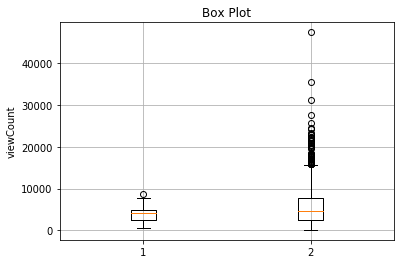

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.boxplot([nextscience, no_nextscience])
plt.xlabel('')
plt.ylabel('viewCount')
plt.title('Box Plot')
plt.grid()
plt.show()

# 넥스트사이언스 포함된 제목의 최대 조회수는?

In [46]:
max(nextscience)

8807

최대 조회수가 1만회를 넘지 못 한다.

# Results
제목에 넥스트사이언스가 있는 영상의 조회수 평균은 4,003회  
제목에 넥스트사이언스가 없는 영상의 조회수 평균은 5,762회  
(p=0.152)  

# Conclusion
조회수 차이는 약 1,700회이나 통계적 유의성을 달성하지 못 했다.   
그러나 넥스트사이언스 영상의 최대 조회수는 8,807회로 1만회를 넘지 못 하는데 이러한 결과는 에이치엘비와 넥스트사이언스를 동시에 제목에 사용하였음에도 달성하지 못한 결과다. '넥스트사이언스'를 제목에 쓰게 되면 조회수 1만 회 이상을 기대할 수 없다. 결과적으로 넥스트사이언스를 제목에 사용하지 않는다.